Loading data from: fullrheinmetal.csv
Initial rows: 2589
Rows after initial preprocessing: 2568

--- Creating Feature Sets ---
Baseline features (8): ['Adj Close_lag_1', 'Open_lag_1', 'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Volume_lag_1', 'Log_Return_lag_1', 'Realized_Volatility_Daily_lag_1']
Rolling features (56): ['Adj Close_lag_1', 'Adj Close_roll_mean_10', 'Adj Close_roll_mean_21']...['Volume_roll_std_21', 'Volume_roll_std_5', 'Volume_roll_std_63']
Calendar features (64): ['Adj Close_lag_1', 'Adj Close_roll_mean_10', 'Adj Close_roll_mean_21']...['quarter', 'weekofyear', 'year']
Technical features (109): ['Adj Close_lag_1', 'Adj Close_lag_10', 'Adj Close_lag_2']...['rsi_14', 'weekofyear', 'year']

--- Running Adaptive Forecast with 8 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)















































































































































































































































































































































































































































































































































































































































































































































































































Adaptive Steps (8 feats): 100%|██████████| 795/795 [01:50<00:00,  7.21it/s]


Finished adaptive forecast. Total time: 110.30 seconds.

--- Running Adaptive Forecast with 56 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)








































































































































Exception ignored in: <function tqdm.__del__ at 0x16186a980>
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/miniconda3/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'





























































































































































































































































































































































































































































Finished adaptive forecast. Total time: 205.14 seconds.

--- Running Adaptive Forecast with 64 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)


Adaptive Steps (64 feats): 100%|██████████| 795/795 [03:10<00:00,  4.17it/s]


Finished adaptive forecast. Total time: 190.83 seconds.

--- Running Adaptive Forecast with 109 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)


Adaptive Steps (109 feats): 100%|██████████| 795/795 [05:08<00:00,  2.57it/s]


Finished adaptive forecast. Total time: 308.92 seconds.

--- Final Evaluation ---

Comparison of Adaptive Forecasts:
Target: Realized_Volatility_Daily
Period: 2022-02-24 to 2025-04-04
------------------------------------------------------------
Feature Set        | RMSE       | MAE        | QLIKE      | Num Feats 
------------------------------------------------------------
Basic              | 5.77       | 3.14       | 0.0088     | 8         
Rolling            | 3.82       | 1.84       | 0.0040     | 56        
Calendar           | 3.86       | 1.85       | 0.0040     | 64        
Technical          | 3.90       | 1.88       | 0.0040     | 109       
------------------------------------------------------------


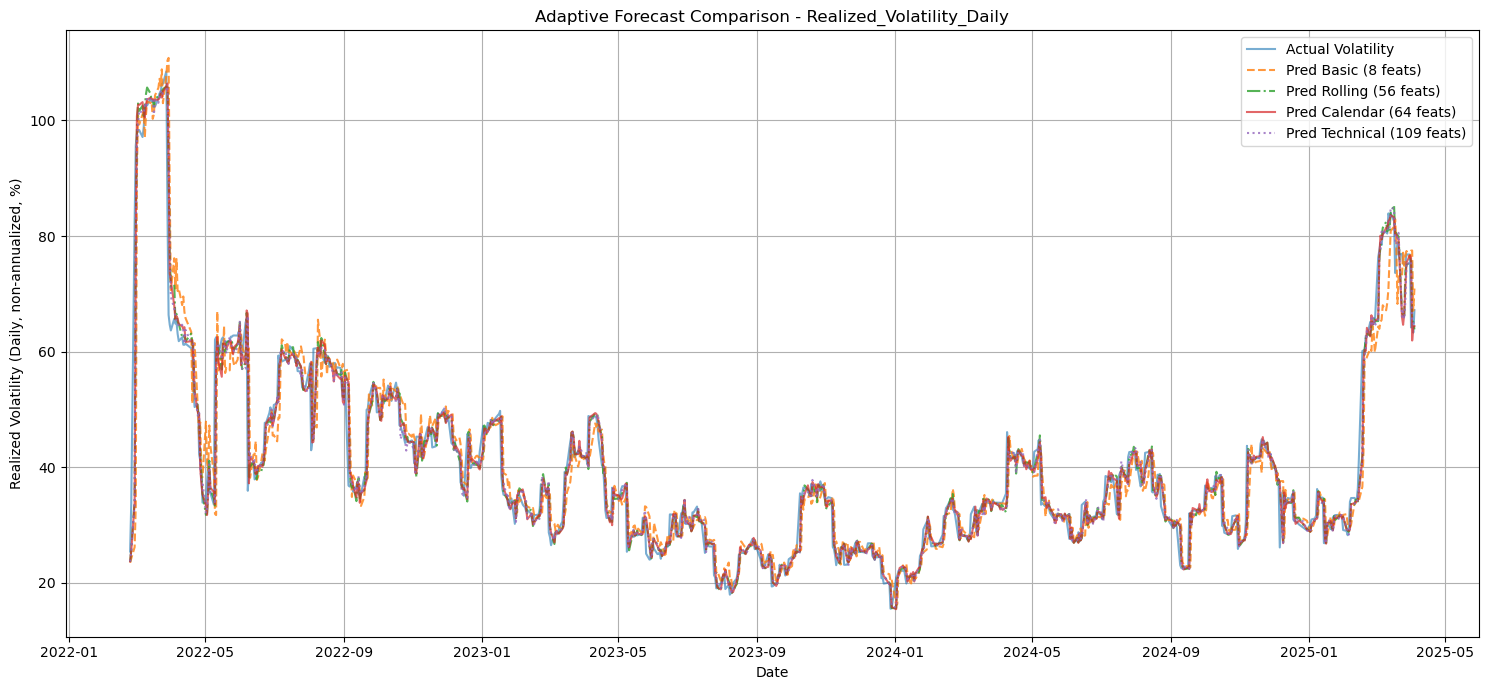

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
import time
from tqdm import tqdm

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

def qlike_loss(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = (y_true > epsilon) & (y_pred > epsilon)
    if mask.sum() == 0:
        return np.nan
    y_true, y_pred = y_true[mask], y_pred[mask]
    ratio = y_true / (y_pred + epsilon)
    ratio = np.maximum(ratio, epsilon)
    loss = ratio - np.log(ratio) - 1
    return np.mean(loss)

def add_lag_features(df, target_col, lags):
    df_out = df.copy()
    cols_to_lag = ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume', 'Log_Return', 'Realized_Volatility_Daily']
    if target_col not in cols_to_lag and target_col in df_out.columns:
        cols_to_lag.append(target_col)
    all_new_features = []
    for col in cols_to_lag:
        if col in df_out.columns:
            for lag in lags:
                feature_name = f'{col}_lag_{lag}'
                if feature_name not in df_out.columns:
                    df_out[feature_name] = df_out[col].shift(lag)
                    all_new_features.append(feature_name)
    return df_out, all_new_features

def add_rolling_features(df, windows):
    df_out = df.copy()
    cols_to_roll = ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume', 'High', 'Low']
    all_new_features = []
    for col in cols_to_roll:
         if col in df_out.columns:
            for window in windows:
                mean_feat = f'{col}_roll_mean_{window}'
                std_feat = f'{col}_roll_std_{window}'
                if mean_feat not in df_out.columns:
                    df_out[mean_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).mean()
                    all_new_features.append(mean_feat)
                if std_feat not in df_out.columns:
                    df_out[std_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).std()
                    all_new_features.append(std_feat)
    return df_out, all_new_features

def add_calendar_features(df):
    df_out = df.copy()
    all_new_features = []
    calendar_cols_funcs = {
        'dayofweek': lambda x: x.index.dayofweek, 'month': lambda x: x.index.month,
        'weekofyear': lambda x: x.index.isocalendar().week.astype(int), 'quarter': lambda x: x.index.quarter,
        'year': lambda x: x.index.year, 'dayofyear': lambda x: x.index.dayofyear,
        'is_month_start': lambda x: x.index.is_month_start.astype(int),
        'is_month_end': lambda x: x.index.is_month_end.astype(int),
    }
    for col, func in calendar_cols_funcs.items():
        if col not in df_out.columns:
            df_out[col] = func(df_out)
            all_new_features.append(col)
    return df_out, all_new_features

def add_technical_indicators(df):
    df_out = df.copy()
    all_new_features = []
    if 'High' in df_out.columns and 'Low' in df_out.columns:
        if 'daily_range' not in df_out.columns:
            df_out['daily_range'] = df_out['High'] - df_out['Low']
            all_new_features.append('daily_range')
        if 'Close' in df_out.columns and 'daily_range' in df_out.columns:
             if 'price_range_pos' not in df_out.columns:
                  if 'daily_range' in df_out.columns:
                      df_out['price_range_pos'] = (df_out['Close'] - df_out['Low']) / (df_out['daily_range'] + 1e-6)
                      df_out['price_range_pos'] = df_out['price_range_pos'].clip(0, 1)
                      all_new_features.append('price_range_pos')
    if 'Adj Close' in df_out.columns:
        if 'rsi_14' not in df_out.columns:
            delta = df_out['Adj Close'].diff(1)
            gain = delta.where(delta > 0, 0.0)
            loss = -delta.where(delta < 0, 0.0)
            avg_gain = gain.ewm(com=14-1, min_periods=14).mean()
            avg_loss = loss.ewm(com=14-1, min_periods=14).mean()
            rs = np.where(avg_loss.abs() > 1e-6, avg_gain / avg_loss, np.inf)
            df_out['rsi_14'] = 100 - (100 / (1 + rs))
            df_out['rsi_14'] = df_out['rsi_14'].replace([np.inf, -np.inf], 100).fillna(50)
            all_new_features.append('rsi_14')
    return df_out, all_new_features

def add_volatility_specific_features(df):
    df_out = df.copy()
    all_new_features = []
    lags_sq = [1, 2, 3, 5]
    if 'Log_Return' in df_out.columns:
        for lag in lags_sq:
            feature_name = f'log_return_sq_lag_{lag}'
            if feature_name not in df_out.columns:
                lag_col_name = f'Log_Return_lag_{lag}'
                if lag_col_name not in df_out.columns:
                    df_out[lag_col_name] = df_out['Log_Return'].shift(lag)
                if lag_col_name in df_out.columns:
                    df_out[feature_name] = df_out[lag_col_name]**2
                    all_new_features.append(feature_name)
    if 'leverage_lag_1' not in df_out.columns:
         lag1_col = 'Log_Return_lag_1'
         if lag1_col not in df_out.columns and 'Log_Return' in df_out.columns:
             df_out[lag1_col] = df_out['Log_Return'].shift(1)
         if lag1_col in df_out.columns:
             df_out['leverage_lag_1'] = (df_out[lag1_col]**2) * (df_out[lag1_col] < 0).astype(int)
             all_new_features.append('leverage_lag_1')
    return df_out, all_new_features

def run_adaptive_forecast(df_full_features, features, target_col, model_params, train_end_date, forecast_end_date):
    print(f"\n--- Running Adaptive Forecast with {len(features)} features ---")
    predictions = {}
    start_time_total = time.time()
    forecast_index = df_full_features.loc[train_end_date + pd.Timedelta(days=1):forecast_end_date].index
    forecast_index = forecast_index.unique().sort_values()
    if forecast_index.empty:
        return pd.Series(dtype=float)
    print(f"Forecasting from {forecast_index.min().strftime('%Y-%m-%d')} to {forecast_index.max().strftime('%Y-%m-%d')} ({len(forecast_index)} steps)")

    for current_date in tqdm(forecast_index, desc=f"Adaptive Steps ({len(features)} feats)"):
        try:
            current_date_loc = df_full_features.index.get_loc(current_date)
            if current_date_loc == 0:
                continue
            train_end_idx_date = df_full_features.index[current_date_loc - 1]
        except (KeyError, IndexError):
            continue

        current_train_data = df_full_features[df_full_features.index <= train_end_idx_date].copy()
        current_train_data['target_for_train'] = current_train_data[target_col].shift(-1)
        current_train_data.dropna(subset=features + ['target_for_train'], inplace=True)

        if current_train_data.empty:
            predictions[current_date] = np.nan
            continue

        X_train = current_train_data[features]
        y_train = current_train_data['target_for_train']
        X_train.columns = X_train.columns.astype(str)
        model = lgb.LGBMRegressor(**model_params)
        try:
            model.fit(X_train, y_train)
        except Exception as e:
            print(f"Fit Error {current_date}: {e}")
            predictions[current_date] = np.nan
            continue

        try:
            features_for_prediction = df_full_features.loc[[train_end_idx_date]][features]
            features_for_prediction.columns = features_for_prediction.columns.astype(str)
        except KeyError:
            predictions[current_date] = np.nan
            continue

        if features_for_prediction.isnull().any().any():
            predictions[current_date] = np.nan
        else:
             try:
                 pred = model.predict(features_for_prediction)[0]
                 predictions[current_date] = pred
             except Exception as e:
                 print(f"Predict Error {current_date}: {e}")
                 predictions[current_date] = np.nan

    print(f"Finished adaptive forecast. Total time: {time.time() - start_time_total:.2f} seconds.")
    return pd.Series(predictions).sort_index()


DATA_FILE_PATH = 'fullrheinmetal.csv'
TARGET_VARIABLE = 'Realized_Volatility_Daily'
TRAIN_END_DATE = pd.to_datetime("2022-02-23")
FORECAST_END_DATE = pd.to_datetime("2025-04-04")
LGBM_PARAMS = { 'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 200, 'learning_rate': 0.05,
                'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1,
                'num_leaves': 15, 'verbose': -1, 'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt' }

print(f"Loading data from: {DATA_FILE_PATH}")
df = pd.read_csv(DATA_FILE_PATH, parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)
print(f"Initial rows: {len(df)}")
required_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"Missing required columns: {required_cols}")
df['Adj Close'] = df['Adj Close'].replace(0, np.nan).ffill()
df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
window = 21
annualization_factor = 260
df['Realized_Volatility_Daily'] = df['Log_Return'].rolling(window=window).std() * np.sqrt(annualization_factor) * 100
df.dropna(inplace=True)
print(f"Rows after initial preprocessing: {len(df)}")

print("\n--- Creating Feature Sets ---")
df_features = df.copy()

df_features, BASE_FEATURES_list = add_lag_features(df_features, TARGET_VARIABLE, lags=[1])
df_features_basic = df_features.copy()
BASE_FEATURES = list(BASE_FEATURES_list)
print(f"Baseline features ({len(BASE_FEATURES)}): {BASE_FEATURES}")
df_features_basic.dropna(subset=BASE_FEATURES, inplace=True)

df_features_rolling = df_features_basic.copy()
df_features_rolling, rolling_features_list = add_rolling_features(df_features_rolling, windows=[5, 10, 21, 63])
ROLLING_FEATURES = sorted(list(set(BASE_FEATURES + rolling_features_list)))
print(f"Rolling features ({len(ROLLING_FEATURES)}): {ROLLING_FEATURES[:3]}...{ROLLING_FEATURES[-3:]}")
df_features_rolling.dropna(subset=ROLLING_FEATURES, inplace=True)

df_features_calendar = df_features_rolling.copy()
df_features_calendar, calendar_features_list = add_calendar_features(df_features_calendar)
CALENDAR_FEATURES = sorted(list(set(ROLLING_FEATURES + calendar_features_list)))
print(f"Calendar features ({len(CALENDAR_FEATURES)}): {CALENDAR_FEATURES[:3]}...{CALENDAR_FEATURES[-3:]}")

df_features_tech = df_features_calendar.copy()
df_features_tech, technical_features_list = add_technical_indicators(df_features_tech)
df_features_tech, vol_specific_features_list = add_volatility_specific_features(df_features_tech)
df_features_tech, more_lags_list = add_lag_features(df_features_tech, TARGET_VARIABLE, lags=[2, 3, 5, 10, 21])

TECHNICAL_FEATURES = sorted(list(set(CALENDAR_FEATURES + technical_features_list + vol_specific_features_list + more_lags_list)))
print(f"Technical features ({len(TECHNICAL_FEATURES)}): {TECHNICAL_FEATURES[:3]}...{TECHNICAL_FEATURES[-3:]}")
df_features_tech.dropna(subset=TECHNICAL_FEATURES, inplace=True)


all_preds = {}

all_preds['Basic'] = run_adaptive_forecast(
    df_features_basic, BASE_FEATURES, TARGET_VARIABLE,
    LGBM_PARAMS, TRAIN_END_DATE, FORECAST_END_DATE
)

all_preds['Rolling'] = run_adaptive_forecast(
    df_features_rolling, ROLLING_FEATURES, TARGET_VARIABLE,
    LGBM_PARAMS, TRAIN_END_DATE, FORECAST_END_DATE
)

all_preds['Calendar'] = run_adaptive_forecast(
    df_features_calendar, CALENDAR_FEATURES, TARGET_VARIABLE,
    LGBM_PARAMS, TRAIN_END_DATE, FORECAST_END_DATE
)

all_preds['Technical'] = run_adaptive_forecast(
    df_features_tech, TECHNICAL_FEATURES, TARGET_VARIABLE,
    LGBM_PARAMS, TRAIN_END_DATE, FORECAST_END_DATE
)

print("\n--- Final Evaluation ---")

valid_preds = {name: preds for name, preds in all_preds.items() if not preds.empty}
if not valid_preds:
    print("No valid predictions were generated.")
else:
    common_index = None
    for preds in valid_preds.values():
        if common_index is None:
            common_index = preds.index
        else:
            common_index = common_index.intersection(preds.index)

    if common_index is None or common_index.empty:
        print("No common index found for predictions.")
    else:
        actuals = df.loc[common_index, TARGET_VARIABLE]
        comparison_df = pd.DataFrame({'Actual': actuals})
        results_metrics = {}

        feature_counts = {
            'Basic': len(BASE_FEATURES),
            'Rolling': len(ROLLING_FEATURES),
            'Calendar': len(CALENDAR_FEATURES),
            'Technical': len(TECHNICAL_FEATURES)
        }

        print("\nComparison of Adaptive Forecasts:")
        print(f"Target: {TARGET_VARIABLE}")
        print(f"Period: {common_index.min().strftime('%Y-%m-%d')} to {common_index.max().strftime('%Y-%m-%d')}")
        print("-" * 60)
        print(f"{'Feature Set':<18} | {'RMSE':<10} | {'MAE':<10} | {'QLIKE':<10} | {'Num Feats':<10}")
        print("-" * 60)

        for name, preds in valid_preds.items():
            preds_common = preds.loc[common_index]
            comparison_df[f'Pred_{name}'] = preds_common
            comparison_df.dropna(inplace=True)

            actuals_eval = comparison_df['Actual']
            preds_eval = comparison_df[f'Pred_{name}']

            if not actuals_eval.empty:
                rmse = mean_squared_error(actuals_eval, preds_eval, squared=False)
                mae = mean_absolute_error(actuals_eval, preds_eval)
                qlike = qlike_loss(actuals_eval, preds_eval)
                num_feats = feature_counts.get(name, 0)

                results_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'QLIKE': qlike, 'Num_Features': num_feats}

                print(f"{name:<18} | {rmse:<10.2f} | {mae:<10.2f} | {qlike:<10.4f} | {num_feats:<10}")
            else:
                 print(f"{name:<18} | {'NaN':<10} | {'NaN':<10} | {'NaN':<10} | {feature_counts.get(name, 0):<10}")


        print("-" * 60)

        plt.figure(figsize=(15, 7))
        plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual Volatility', alpha=0.6, linewidth=1.5)
        if 'Pred_Basic' in comparison_df.columns:
             plt.plot(comparison_df.index, comparison_df['Pred_Basic'], label=f'Pred Basic ({feature_counts.get("Basic", 0)} feats)', linestyle='--', alpha=0.8)
        if 'Pred_Rolling' in comparison_df.columns:
             plt.plot(comparison_df.index, comparison_df['Pred_Rolling'], label=f'Pred Rolling ({feature_counts.get("Rolling", 0)} feats)', linestyle='-.', alpha=0.8)
        if 'Pred_Calendar' in comparison_df.columns:
             plt.plot(comparison_df.index, comparison_df['Pred_Calendar'], label=f'Pred Calendar ({feature_counts.get("Calendar", 0)} feats)', linestyle='-', alpha=0.7)
        if 'Pred_Technical' in comparison_df.columns:
             plt.plot(comparison_df.index, comparison_df['Pred_Technical'], label=f'Pred Technical ({feature_counts.get("Technical", 0)} feats)', linestyle=':', alpha=0.8)

        plt.title(f'Adaptive Forecast Comparison - {TARGET_VARIABLE}')
        plt.xlabel('Date')
        plt.ylabel('Realized Volatility (Daily, non-annualized, %)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()